In [185]:
# import wind data
import pandas as pd
df_wine = pd.read_csv('wine.data',header=None)
df_wine.columns=['Class label','Alcohol','Malic acid','Ash','Alcalinity of ash','Magnesium','Total phenols','Flavanoids'
                ,'Nonflavanoid phenols','Proanthocynins','Color intensity','Hue','OD280/OD315 of diluted wines',
                'Proline']
df_wine = df_wine[df_wine['Class label'] !=1] # drop 1 class
y = df_wine['Class label'].values
X = df_wine[['Alcohol','OD280/OD315 of diluted wines']].values
# encode the data and split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
le = LabelEncoder()
y = le.fit_transform(y)
y[y==0] = -1
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1,stratify=y)

In [186]:
# Adaboost from scratch
# Reference: Sergios Theordoridis book
import numpy as np
#from Decision_tree import Decision_Tree
from sklearn.tree import DecisionTreeClassifier

class Adaboost(object):
    
    def __init__(self,N_classifiers=50,max_depth=1):
        self.N_classifiers = N_classifiers
        self.max_depth = max_depth
    
    def train(self,X,y):
        N = X.shape[0]
        w = 1/N*np.ones((N)) # initialize the weight
        a = np.zeros((self.N_classifiers,1))
        classifiers = []

        for i in range(self.N_classifiers):
            # compute the optimum theta in the stump by minimizing the weighted error rate P
            #tree = Decision_Tree(impurity_fun='entropy',max_depth=self.max_depth)
            tree = DecisionTreeClassifier(max_depth=self.max_depth,criterion='entropy',random_state=1)
            #print(w)
            tree.fit(X,y,w)
            #print(tree.root.split)
            #print(tree.root.lchild.split)
            #print(tree.root.rchild.split)


            y_hat = tree.predict(X)
            idx_wrong = y_hat != y
            P = sum(w[idx_wrong])
            #print(P)
            a[i] = 0.5*np.log((1-P)/P)


            #print(y_hat)
            w = w*np.exp(-y*a[i]*y_hat)
            Z = sum(w)

            #print(w)
            w = w/Z # normalize the weight 
            #print(w)
            classifiers.append(tree)
        self.a=a
        self.classifiers = classifiers
        
    def predict(self,x):
        return np.sign(sum(self.a*[cl.predict(x) for cl in self.classifiers]))

    #def predict(self,X):
    #    return np.concatenate([self.predict1(x) for x in X])
    

In [187]:
ada = Adaboost(N_classifiers=100,max_depth=1)
ada.train(X_train,y_train)
#ada.predict(X_test)

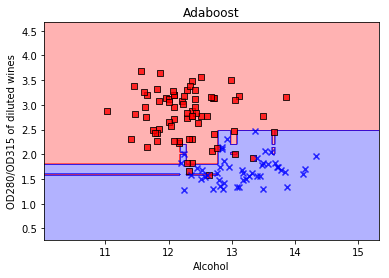

In [188]:
import matplotlib.pyplot as plt
from Perceptron import plot_decision_regions

plt.figure()
plot_decision_regions(X,y,classifier=ada)
plt.title('Adaboost')
plt.xlabel('Alcohol')
plt.ylabel('OD280/OD315 of diluted wines')
plt.show()